# ImageNet Benchmark

Interactive plot of ImageNet challenge benchmark.  Data is queried from [papers with code](https://paperswithcode.com/).<!-- END_TEASER -->

In [1]:
# package requirements:
# bokeh
# beautifulsoup4
# pandas>=0.25.1

In [2]:
import requests
import bs4
import json
import pandas as pd

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.models.tools import HoverTool
from bokeh.palettes import Spectral7
from bokeh.transform import factor_cmap
from bokeh.core.properties import value
from bokeh.embed import file_html
from bokeh.resources import INLINE
from IPython.display import HTML

In [3]:
# Get data
result = requests.get("https://paperswithcode.com/sota/image-classification-on-imagenet")
result = result.content
doc = bs4.BeautifulSoup(result)

In [4]:
# preprocess data
data = doc.find(id="evaluation-table-data").string
data = json.loads(data)

In [5]:
def convert_num(d):
  if not d:
    return None
  else:
    if d[-1]=="M":
      return float(d[:-1])*1e6
    elif d[-1] == "%":
      return float(d[:-1])
    else:
      return None

def parse_fn(row):
  d = {}
  d['model'] = row['method']
  d['nparam'] = convert_num(row['metrics']['Number of params'])
  d['size'] = row['metrics']['Number of params']
  d['Top1'] = convert_num(row['metrics']['Top 1 Accuracy'])
  d['Top5'] = convert_num(row['metrics']['Top 5 Accuracy'])
  d['year'] = row['evaluation_date'].split("-")[0][2:]
  d['shortname'] = d['model'].replace("-"," ").split(" ")[0]
  return d

In [6]:
df = pd.DataFrame(map(parse_fn, data))
df = df[df['nparam'].notna()]
df.insert(6, "rad", (df['nparam']/1e6)**0.5*3, True)
df = df.sort_values(by=['year'])

years = list(df.year.unique())

In [7]:
# https://programminghistorian.org/en/lessons/visualizing-with-bokeh

df_clean = df[df['Top1'].notna()]

dfs = ColumnDataSource(df_clean) 
p = figure(plot_width=700, plot_height=400, x_axis_type='log', title="ImageNet Challenge Benchmark")

color_map = factor_cmap(field_name='year',
                    palette=Spectral7, factors=years)

p.circle(source=dfs, x='nparam',y='Top1', color=color_map, size='rad', legend='year', alpha=0.5)

hover = HoverTool()
hover.tooltips = [('model','@model'),('Top5','@Top5')]
p.add_tools(hover)

# labels = LabelSet(x='nparam', y='Top1', x_offset=-20, y_offset=1, source=dfs, text='shortname', text_font_size="8pt")

p.legend.location = 'bottom_left'
p.legend.orientation = 'horizontal'
p.yaxis.axis_label = "Top 1 Accuracy [%]"
p.xaxis.axis_label = "Model Size [Number of Parameters]"
# p.add_layout(labels)
#show(p)

In [8]:
html = file_html(p, INLINE)


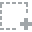
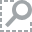
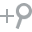
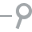
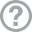
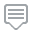
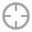
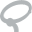
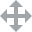
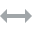
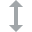
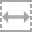
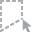
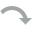
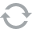
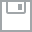
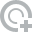
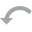
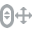
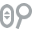
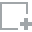
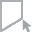
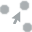
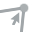

In [9]:
HTML(html)